In [17]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchaudio
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [4]:
import sys
!{sys.executable} -m pip install torch torchvision torchaudio

  Using cached filelock-3.24.3-py3-none-any.whl.metadata (2.0 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached fsspec-2026.2.0-py3-none-any.whl.metadata (10 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 MB 11.1 MB/s  0:00:07m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 734.9/734.9 kB 9.0 MB/s  0:00:00
Using cached fsspec-2026.2.0-py3-none-any.whl (202 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.0 MB/s  0:00:00
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
Using cached filelock-3.24.3-py3-none-any.whl (24 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [torchaudio]8 [torchaudio]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.005843889..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.015211772..1.0000001].



Batch 1
Batch size: 64


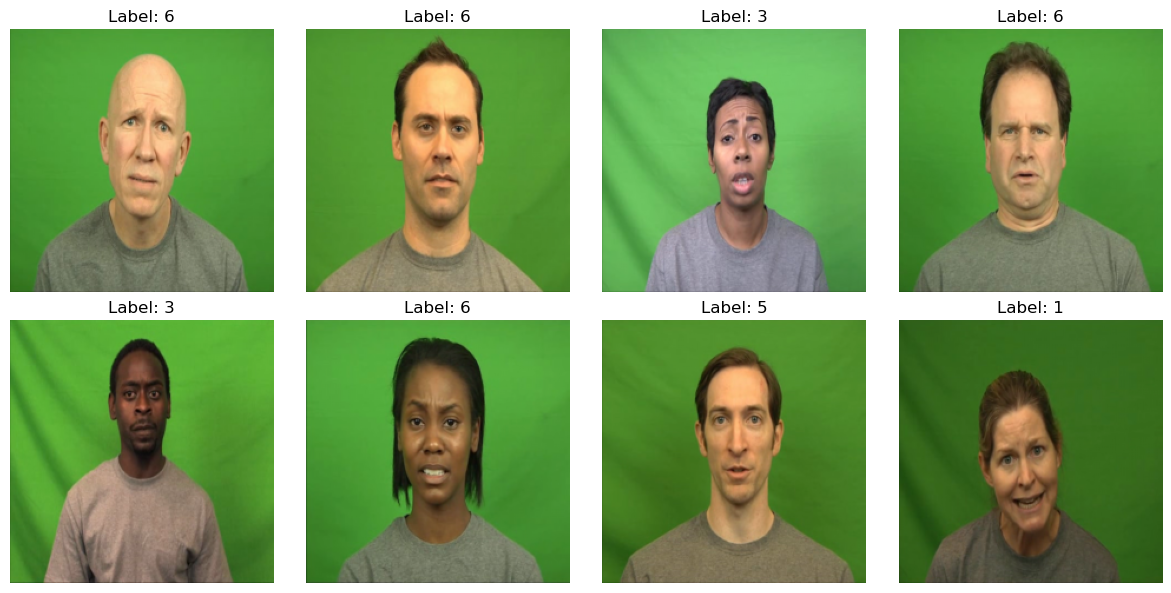

In [23]:
csv_path = "/Users/anzheladavityan/Desktop/crema-d-mirror/crema_data_manifest.csv"
df = pd.read_csv(csv_path)

# Filter only videos
video_df = df[df['file_type'] == 'video'].reset_index(drop=True)

# -------------------------------
# 2️⃣ Train/Val/Test Split (60/20/20)
# -------------------------------
total = len(video_df)
train_size = int(0.6 * total)
val_size = int(0.2 * total)
test_size = total - train_size - val_size

train_df, val_df, test_df = random_split(
    video_df, 
    [train_size, val_size, test_size], 
    generator=torch.Generator().manual_seed(42)
)

# -------------------------------
# 3️⃣ Define PyTorch Dataset
# -------------------------------
class CremaVideoDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        video_path = row['file_path']
        frame_idx = int(row['frame_idx'])
        emotion = int(row['Emotion'])  # numeric label

        # Read the frame
        cap = cv2.VideoCapture(video_path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        cap.release()

        if not ret:
            raise ValueError(f"Cannot read frame {frame_idx} from {video_path}")

        # Convert BGR → RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if self.transform:
            frame = self.transform(frame)

        return frame, emotion

# -------------------------------
# 4️⃣ Define Transform
# -------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),           # H,W,C → C,H,W
    transforms.Resize((224, 224))    # optional
])

# -------------------------------
# 5️⃣ Create Datasets & DataLoaders
# -------------------------------
train_dataset = CremaVideoDataset(pd.DataFrame(train_df.dataset), transform=transform)
val_dataset = CremaVideoDataset(pd.DataFrame(val_df.dataset), transform=transform)
test_dataset = CremaVideoDataset(pd.DataFrame(test_df.dataset), transform=transform)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# -------------------------------
# 6️⃣ Function to display 8 frames in 2x4 grid
# -------------------------------
def show_batch_2x4(batch_frames, batch_labels, max_samples=8):
    n = min(max_samples, len(batch_frames))
    rows = 2
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    
    for i in range(n):
        r = i // cols
        c = i % cols
        frame = batch_frames[i].permute(1, 2, 0).numpy()  # C,H,W → H,W,C
        axes[r, c].imshow(frame)
        axes[r, c].set_title(f"Label: {batch_labels[i].item()}")
        axes[r, c].axis('off')
    
    # Hide any unused subplots
    for j in range(n, rows*cols):
        r = j // cols
        c = j % cols
        axes[r, c].axis('off')
    
    plt.tight_layout()
    plt.show()

# -------------------------------
# 7️⃣ Example: first batch from train_loader
# -------------------------------
for batch_idx, (frames, labels) in enumerate(train_loader):
    print(f"\nBatch {batch_idx+1}")
    print(f"Batch size: {frames.size(0)}")
    show_batch_2x4(frames, labels, max_samples=8)
    break


Batch 1
Batch size: 64


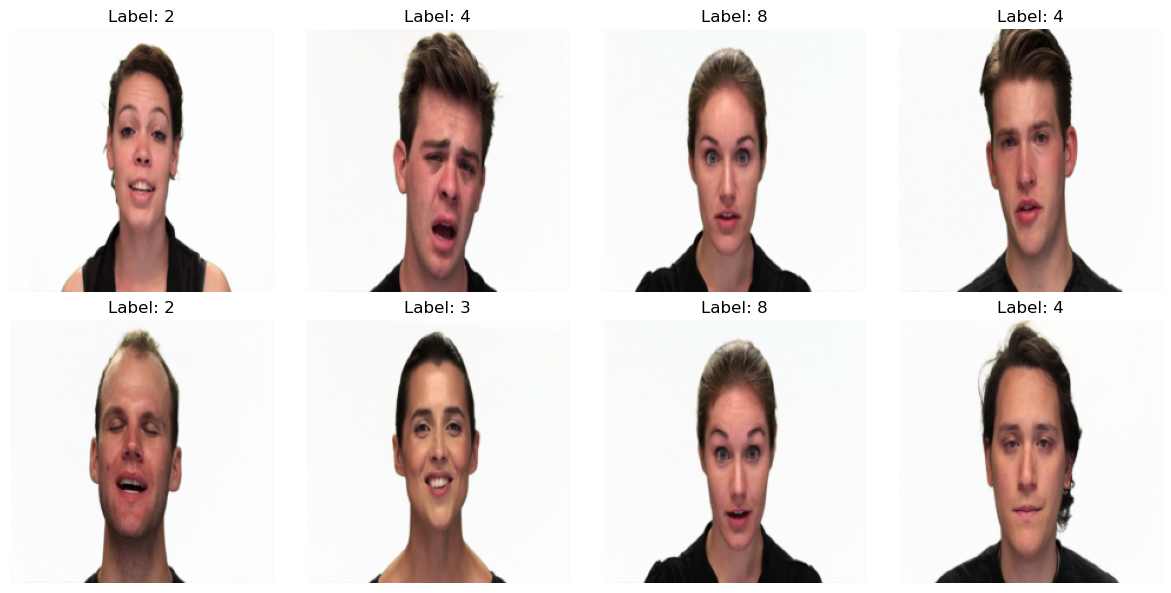

In [22]:
csv_path = "/Users/anzheladavityan/Desktop/RAVDESS/rv_data_manifest.csv"
df = pd.read_csv(csv_path)

# Filter only video rows (modality 02)
video_df = df[df['file_type'] == 'video'].reset_index(drop=True)

# -------------------------------
# 2️⃣ Train/Val/Test Split (60/20/20)
# -------------------------------
total = len(video_df)
train_size = int(0.6 * total)
val_size = int(0.2 * total)
test_size = total - train_size - val_size

train_df, val_df, test_df = random_split(
    video_df, 
    [train_size, val_size, test_size], 
    generator=torch.Generator().manual_seed(42)
)

# -------------------------------
# 3️⃣ Define PyTorch Dataset
# -------------------------------
class RavdessVideoDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        video_path = row['file_path']
        frame_idx = int(row['frame_idx'])
        emotion = int(row['Emotion'])  # numeric label

        # Read frame
        cap = cv2.VideoCapture(video_path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        cap.release()

        if not ret:
            raise ValueError(f"Cannot read frame {frame_idx} from {video_path}")

        # Convert BGR → RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if self.transform:
            frame = self.transform(frame)

        return frame, emotion

# -------------------------------
# 4️⃣ Transform
# -------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),           # H,W,C → C,H,W
    transforms.Resize((224, 224))    # optional
])

# -------------------------------
# 5️⃣ Create Datasets & DataLoaders
# -------------------------------
train_dataset = RavdessVideoDataset(pd.DataFrame(train_df.dataset), transform=transform)
val_dataset = RavdessVideoDataset(pd.DataFrame(val_df.dataset), transform=transform)
test_dataset = RavdessVideoDataset(pd.DataFrame(test_df.dataset), transform=transform)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# -------------------------------
# 6️⃣ Function to display 8 frames in 2x4 grid
# -------------------------------
def show_batch_2x4(batch_frames, batch_labels, max_samples=8):
    n = min(max_samples, len(batch_frames))
    rows = 2
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    
    for i in range(n):
        r = i // cols
        c = i % cols
        frame = batch_frames[i].permute(1, 2, 0).numpy()  # C,H,W → H,W,C
        axes[r, c].imshow(frame)
        axes[r, c].set_title(f"Label: {batch_labels[i].item()}")
        axes[r, c].axis('off')
    
    # Hide any unused subplots
    for j in range(n, rows*cols):
        r = j // cols
        c = j % cols
        axes[r, c].axis('off')
    
    plt.tight_layout()
    plt.show()

# -------------------------------
# 7️⃣ Example: first batch from train_loader
# -------------------------------
for batch_idx, (frames, labels) in enumerate(train_loader):
    print(f"\nBatch {batch_idx+1}")
    print(f"Batch size: {frames.size(0)}")
    show_batch_2x4(frames, labels, max_samples=8)
    break